# Basket Option Pricing
### Objective

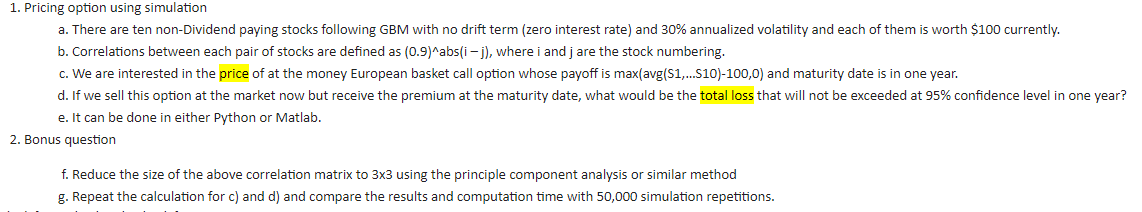

#### According to the Black-Scholes Formula, the European Vanilla option on the mentioned stock has an ATM value of USD 11.923. When dealing with a basket option on highly correlated stocks, the value of the option should not exceed this amount due to the averaging of prices, which reduces the contract's volatility. In the unique scenario where all 10 stocks are perfectly correlated, the basket option's price would be equal to that of the vanilla option. This rule of thumb will be instrumental in verifying the following pricing implementations.

In [1]:
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
basket_size = 10
vol = 0.3  # annualized
expiry = 1 # year
S_0 = 100 # All start at $100
K = 100 # Strike
num_simulations = 50000
conf_perc = 0.95 # Confidence Percentile

In [3]:
# Generate correlation matrix
corr_matrix = np.zeros((basket_size, basket_size))
for i in range(basket_size):
    for j in range(basket_size):
        corr_matrix[i, j] = 0.9 ** abs(i - j)
print(corr_matrix)

[[1.         0.9        0.81       0.729      0.6561     0.59049
  0.531441   0.4782969  0.43046721 0.38742049]
 [0.9        1.         0.9        0.81       0.729      0.6561
  0.59049    0.531441   0.4782969  0.43046721]
 [0.81       0.9        1.         0.9        0.81       0.729
  0.6561     0.59049    0.531441   0.4782969 ]
 [0.729      0.81       0.9        1.         0.9        0.81
  0.729      0.6561     0.59049    0.531441  ]
 [0.6561     0.729      0.81       0.9        1.         0.9
  0.81       0.729      0.6561     0.59049   ]
 [0.59049    0.6561     0.729      0.81       0.9        1.
  0.9        0.81       0.729      0.6561    ]
 [0.531441   0.59049    0.6561     0.729      0.81       0.9
  1.         0.9        0.81       0.729     ]
 [0.4782969  0.531441   0.59049    0.6561     0.729      0.81
  0.9        1.         0.9        0.81      ]
 [0.43046721 0.4782969  0.531441   0.59049    0.6561     0.729
  0.81       0.9        1.         0.9       ]
 [0.38742049 0.4

### Test and sanity check with built in multivariate library (utilizes svd to sample)

In [114]:
# Covariance Matrix of perfect correlation
#cov_matrix_1 = (np.full((basket_size,basket_size),0.9)+np.diag(np.full(basket_size,1)))-np.diag(np.full(basket_size,0.9))
cov_matrix_1 = np.full((basket_size,basket_size),1.0)
cov_matrix_1 = (vol**2)*cov_matrix_1
cov_matrix_1

array([[0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09],
       [0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09],
       [0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09],
       [0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09],
       [0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09],
       [0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09],
       [0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09],
       [0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09],
       [0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09],
       [0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09]])

#### With a near perfect correlation matrix, the basket is priced at almost exactly the vanilla counter part as shown below, passing our validation

In [118]:
means = np.zeros(basket_size)
initial_spots = np.full(basket_size,S_0)
basket_avg = []

start_time = time.time()

dW = np.random.default_rng().multivariate_normal(means,cov_matrix_1,num_simulations)
for i in range(num_simulations):
    dw = dW[i]
    final_spots = initial_spots * np.exp(-0.5*vol**2*expiry) * np.exp(np.sqrt(expiry) * dw)
    basket_avg.append(final_spots.mean())
    
option_prices = np.array(basket_avg)-K
option_prices[option_prices < 0] = 0
mc_price = option_prices.mean()

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")
print(f"Option Price: ${round(mc_price,3)}")

Elapsed time: 1.1985723972320557 seconds
Option Price: $11.826


#### Now we price under the covariance of interest. Note that the covariance of interest indicates a strong correlation amongst the 10 underyling stocks. We should expect a price below, but fairly close to the vanilla.

In [119]:
means = np.zeros(basket_size)
cov_matrix = (vol**2)*corr_matrix
initial_spots = np.full(basket_size,S_0)
basket_avg = []

start_time = time.time()

dW = np.random.default_rng().multivariate_normal(means,cov_matrix,num_simulations)
for i in range(num_simulations):
    dw = dW[i]
    final_spots = initial_spots * np.exp(-0.5*vol**2*expiry) * np.exp(np.sqrt(expiry) * dw)
    basket_avg.append(final_spots.mean())
    
option_prices = np.array(basket_avg)-K
option_prices[option_prices < 0] = 0
mc_price = option_prices.mean()

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")
print(f"Option Price: ${round(mc_price,3)}")

Elapsed time: 1.2081081867218018 seconds
Option Price: $10.145


#### As expected, we obtain a price fairly close to vanilla. Now we want to calculate VaR of the sold option.

In [6]:
total_net = mc_price - option_prices
total_net.sort()
index = round(num_simulations*(1-conf_perc))-1
print(f"Total Loss not exceeding 95% confidence: ${total_net[index]}")

Total Loss not exceeding 95% confidence: $-37.4097907177831


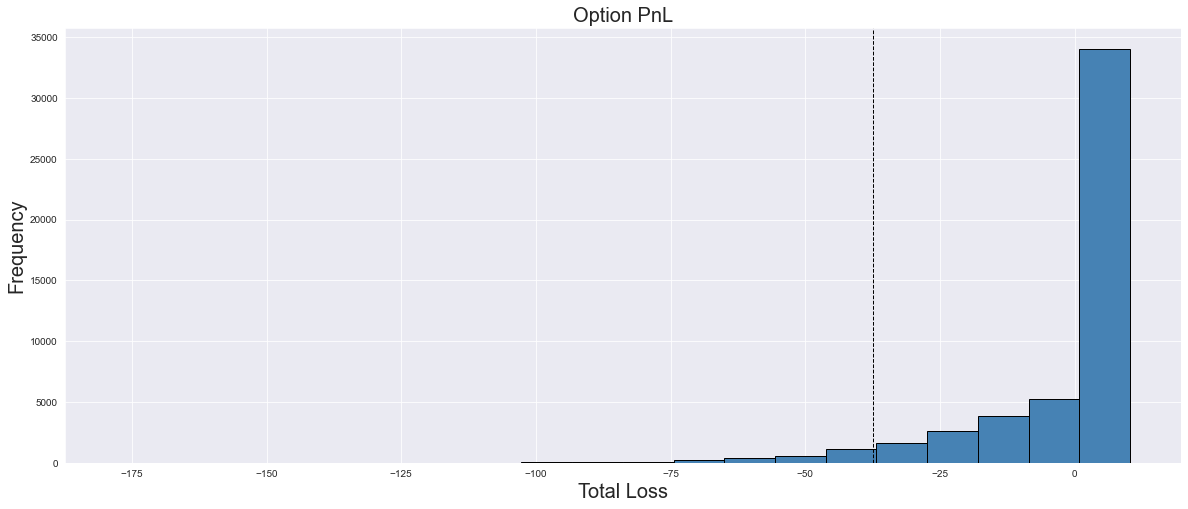

In [7]:
sns.set_style ("darkgrid")
plt.figure(figsize=(20,8))
plt.hist(total_net, bins=20, color='steelblue', edgecolor='black')
plt.axvline(total_net[index], color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Total Loss', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title('Option PnL', fontsize=20)
plt.show()

### Cholesky Implementation

#### Cholesky decomposition requires that the covariance matrix is positive definite, but because a perfectly correlation matrix is not positive definite, we have to test with a nearly perfect correlation matrix instead.

In [121]:
cov_matrix_1 = (np.full((basket_size,basket_size),0.9)+np.diag(np.full(basket_size,1)))-np.diag(np.full(basket_size,0.9))
cov_matrix_1 = (vol**2)*cov_matrix_1

In [122]:
means = np.zeros(basket_size)
initial_spots = np.full(basket_size,S_0)
basket_avg = []

start_time = time.time()

# Generate a matrix of standard normal variables
matrix_normal = np.random.randn(num_simulations, basket_size)
lower_triangular_matrix = np.linalg.cholesky(cov_matrix_1)
dW = np.dot(matrix_normal,lower_triangular_matrix.T)
for i in range(num_simulations):
    dw = dW[i]
    final_spots = initial_spots * np.exp(-0.5*vol**2*expiry) * np.exp(np.sqrt(expiry) * dw)
    basket_avg.append(final_spots.mean())
    
option_prices = np.array(basket_avg)-K
option_prices[option_prices < 0] = 0
mc_price = option_prices.mean()

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")
print(f"Option Price: ${round(mc_price,3)}")

Elapsed time: 1.2499377727508545 seconds
Option Price: $11.48


#### As expected, a price very close to the vanilla. 

#### Lets now apply this Monte Carlo + Cholesky to pricet the original basket.

In [124]:
initial_spots = np.full(basket_size,S_0)
basket_avg = []

start_time = time.time()

# Generate a matrix of standard normal variables
matrix_normal = np.random.randn(num_simulations, basket_size)
lower_triangular_matrix = np.linalg.cholesky(cov_matrix)
dW = np.dot(matrix_normal,lower_triangular_matrix.T)
for i in range(num_simulations):
    dw = dW[i]
    final_spots = initial_spots * np.exp(-0.5*vol**2*expiry) * np.exp(np.sqrt(expiry) * dw)
    basket_avg.append(final_spots.mean())
    
option_prices = np.array(basket_avg)-K
option_prices[option_prices < 0] = 0
mc_price = option_prices.mean()

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")
print(f"Option Price: ${round(mc_price,3)}")

Elapsed time: 1.2090599536895752 seconds
Option Price: $10.299


In [125]:
total_net = mc_price - option_prices
total_net.sort()
index = round(num_simulations*(1-conf_perc))-1
print(f"Total Loss not exceeding 95% confidence: ${total_net[index]}")

Total Loss not exceeding 95% confidence: $-37.94159100857177


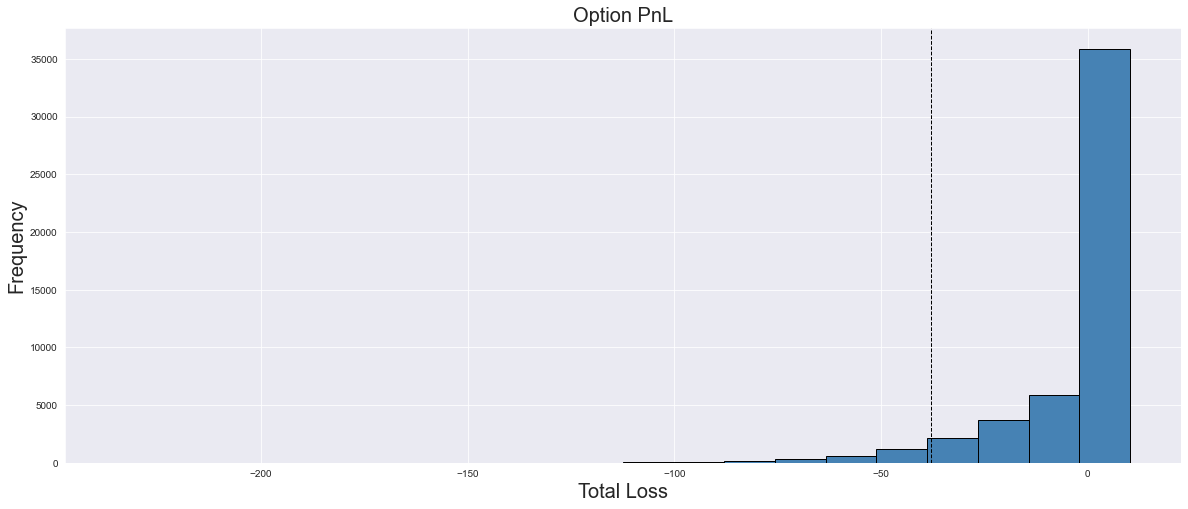

In [126]:
plt.figure(figsize=(20,8))
plt.hist(total_net, bins=20, color='steelblue', edgecolor='black')
plt.axvline(total_net[index], color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Total Loss', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title('Option PnL', fontsize=20)
plt.show()

### BONUS: PCA Implementation

#### Originally attempted this with pythons sklearn module, but could not generate principal components that recovered original covariance matrix, so I decided to move on with numpy.

In [127]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

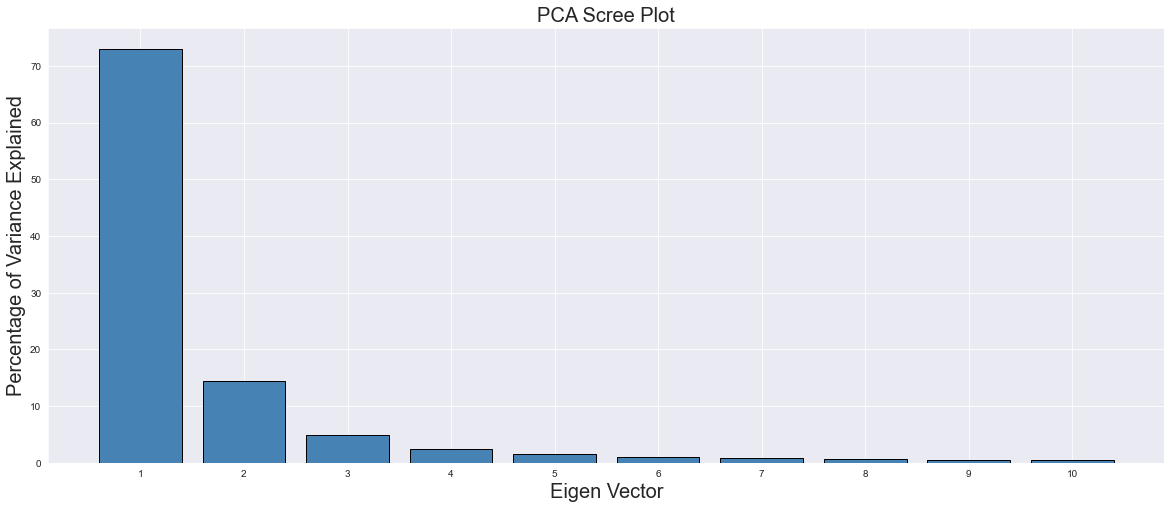

In [128]:
sns.set_style ("darkgrid")
variance_ratios = eigenvalues / eigenvalues.sum()
percent_variance = np.round(variance_ratios * 100, decimals =2)
columns = ['1','2','3','4','5','6','7','8','9','10']
plt.figure(figsize=(20,8))
plt.bar(x= range(1,11), height=percent_variance, tick_label=columns, color='steelblue', edgecolor='black')
plt.ylabel('Percentage of Variance Explained', fontsize=20)
plt.xlabel('Eigen Vector', fontsize=20)
plt.title('PCA Scree Plot', fontsize=20)
plt.show()

#### Using numpy, the first three eigen-vectors capture 83% of the variation. Below you can see how close the reconstructed covariance matrix is to the original.

In [135]:
# Sort eigenvalues and eigenvectors in decreasing order
sort_indices = np.argsort(eigenvalues)[::-1]  # Get the sorted indices in descending order
sorted_eigenvalues = eigenvalues[sort_indices]
sorted_eigenvectors = eigenvectors[:, sort_indices]

# Select the top 3 eigenvalues and eigenvectors
top_eigenvalues = sorted_eigenvalues[:3]
top_eigenvectors = sorted_eigenvectors[:, :3]

reduced_matrix = np.dot(top_eigenvectors, np.dot(np.diag(top_eigenvalues), top_eigenvectors.T))

# Print the reduced matrix
print("Approx. of the original covariance matrix:")
print(reduced_matrix)


Approx. of the original covariance matrix:
[[0.08248214 0.08334956 0.07795563 0.06880838 0.0588735  0.05055253
  0.04496637 0.0418043  0.0397588  0.03732401]
 [0.08334956 0.08542317 0.08199787 0.07490159 0.06637476 0.05834259
  0.0518871  0.0471013  0.04334539 0.0397588 ]
 [0.07795563 0.08199787 0.08236913 0.07956425 0.07437068 0.06770933
  0.06047752 0.05342819 0.0471013  0.0418043 ]
 [0.06880838 0.07490159 0.07956425 0.08183822 0.08089881 0.07650561
  0.06925042 0.06047752 0.0518871  0.04496637]
 [0.0588735  0.06637476 0.07437068 0.08089881 0.08397315 0.0824399
  0.07650561 0.06770933 0.05834259 0.05055253]
 [0.05055253 0.05834259 0.06770933 0.07650561 0.0824399  0.08397315
  0.08089881 0.07437068 0.06637476 0.0588735 ]
 [0.04496637 0.0518871  0.06047752 0.06925042 0.07650561 0.08089881
  0.08183822 0.07956425 0.07490159 0.06880838]
 [0.0418043  0.0471013  0.05342819 0.06047752 0.06770933 0.07437068
  0.07956425 0.08236913 0.08199787 0.07795563]
 [0.0397588  0.04334539 0.0471013  0.0

In [139]:
eigenvalues_1, eigenvectors_1 = np.linalg.eig(cov_matrix_1)
sort_indices = np.argsort(eigenvalues_1)[::-1]
sorted_eigenvalues = eigenvalues_1[sort_indices]
sorted_eigenvectors = eigenvectors_1[:, sort_indices]
top_eigenvalues_1 = sorted_eigenvalues[:3]
top_eigenvectors_1 = sorted_eigenvectors[:, :3]

start_time = time.time()

initial_spots = np.full(basket_size,S_0)
L = top_eigenvectors_1*top_eigenvalues_1**0.5
std_norm = np.random.randn(num_simulations,3)
dW = np.array([np.dot(L,std) for std in std_norm])
final_spots = initial_spots * np.exp(-0.5*vol**2*expiry) * np.exp(np.sqrt(expiry) * dW)
basket_avg = np.array([final.mean() for final in final_spots])
option_prices = basket_avg - K
option_prices[option_prices<0]=0
mc_price = option_prices.mean()

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")
print(f"Option Price: ${round(mc_price,3)}")

Elapsed time: 0.5371363162994385 seconds
Option Price: $11.357


#### Although much faster (about half the time), the simulated price is not as close to the theoretical vanilla value. This was expected because the reconstructed covariance matrix showed slighty less correlation which drags the price down.

In [136]:
start_time = time.time()

initial_spots = np.full(basket_size,S_0)
L = top_eigenvectors*top_eigenvalues**0.5
std_norm = np.random.randn(num_simulations,3)
dW = np.array([np.dot(L,std) for std in std_norm])
final_spots = initial_spots * np.exp(-0.5*vol**2*expiry) * np.exp(np.sqrt(expiry) * dW)
basket_avg = np.array([final.mean() for final in final_spots])
option_prices = basket_avg - K
option_prices[option_prices<0]=0
mc_price = option_prices.mean()

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")
print(f"Option Price: ${round(mc_price,3)}")

Elapsed time: 0.5865452289581299 seconds
Option Price: $10.076


In [137]:
total_net = mc_price - option_prices
total_net.sort()
index = round(num_simulations*(1-conf_perc))-1
print(f"Total Loss not exceeding 95% confidence: ${total_net[index]}")

Total Loss not exceeding 95% confidence: $-36.589196890818336


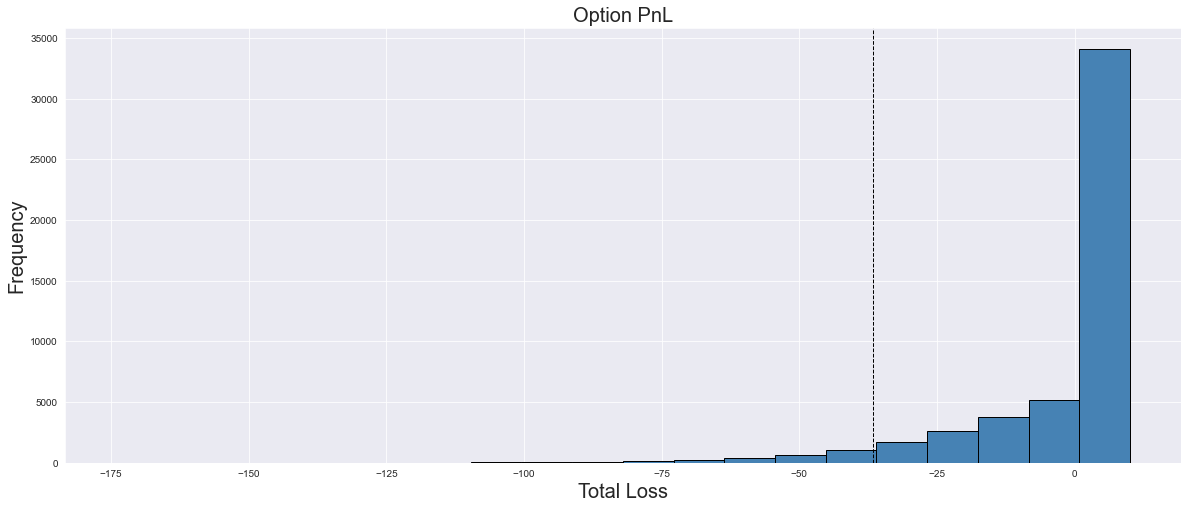

In [138]:
plt.figure(figsize=(20,8))
plt.hist(total_net, bins=20, color='steelblue', edgecolor='black')
plt.axvline(total_net[index], color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Total Loss', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title('Option PnL', fontsize=20)
plt.show()